In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('../data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


Characters dataset splitted in males and females to easily compare among genders

In [4]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

Text(0.5, 0, 'Adult actor height (m)')

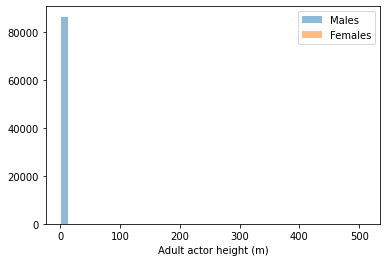

In [5]:
LIMIT_CHILDREN_AGE = 14
characters_male_height = characters_male.dropna(subset=['actor_height_meters'])
characters_female_height = characters_female.dropna(subset=['actor_height_meters'])
characters_male_height = characters_male_height[(characters_male_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
characters_female_height = characters_female_height[(characters_female_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
plt.hist(characters_male_height['actor_height_meters'],bins=40, alpha=0.5)
plt.hist(characters_female_height['actor_height_meters'],bins=25, alpha=0.5)
plt.legend(['Males', 'Females'])
plt.xlabel('Adult actor height (m)')


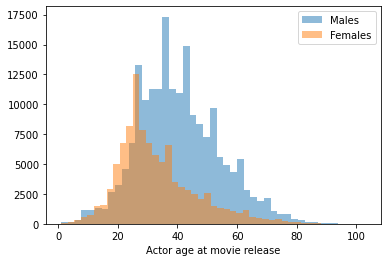

In [5]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

In [ ]:
def characters_etnicity_pie(characters):
    characters_etnicity = characters.dropna(subset=['actor_ethnicity_freebase_id'])
    ethnicities, counts = np.unique(characters_etnicity['actor_ethnicity_freebase_id'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 2
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    #print('HELLO', plot_ethnicities)
    plot_ethnicities = fetch_ethnicity_freebase_labels(plot_ethnicities)
    
    plot_ethnicities.append('Others')
    plot_counts.append(others_count)
    
    plt.pie(plot_counts, labels=plot_ethnicities)
    plt.legend()
    plt.show()


characters_etnicity_pie(characters)
#characters_etnicity_pie(characters_female)

In [ ]:
import requests
import time

ethnicity = '/m/033tf_'
ethnicity[4:]

In [ ]:
ethnicity_freebase_ids = ['/m/041rx', '/m/033tf_', '/m/0x67']
def fetch_ethnicity_freebase_labels(ethnicity_freebase_ids):
    ethnicity_labels = []

    for ehtnicity_id in ethnicity_freebase_ids:
        time.sleep(1) # Necessary to avoid server refusing the request

        query = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F0" \
        + ehtnicity_id[4:] \
        + "%22%20%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D"

        try:
            response = requests.get(query)
            ethnicity_wikidata_dict = response.json()
            try:
                ethnicity_label = ethnicity_wikidata_dict['results']['bindings'][0]['sLabel']['value']
            except:
                ethnicity_label = 'unknown'
        except ValueError:
            print(ValueError)
            ethnicity_label = ehtnicity_id

        print(ethnicity_label)
        ethnicity_labels.append(ethnicity_label)

    return ethnicity_labels
fetch_ethnicity_freebase_labels(ethnicity_freebase_ids)